In [1]:
import numpy as np
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
print(mnist["DESCR"])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
# Each image is 28px x 28px, resulting in 784 features.

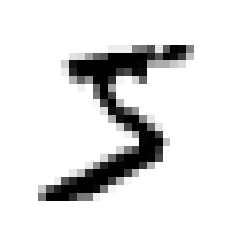

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
_ = plt.axis("off")

In [7]:
# What does the label tells us about the image above?
y[0]

'5'

In [8]:
# The label is a string. Cast them to integer.
y = y.astype(np.uint8)
y.dtypes

dtype('uint8')

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier

In [10]:
y_train_5 = y_train == 5  # True for all 5, false for other digits
y_test_5 = y_test == 5

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

## Performance measure

In [12]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds, y_train_folds = X_train.iloc[train_index], y_train_5[train_index]
    X_test_folds, y_test_folds = X_train.iloc[test_index], y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [13]:
from sklearn.model_selection import cross_val_score

# help(cross_val_score)
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="constant", constant=0)
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [15]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype="bool")

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred, normalize=None)

array([[53892,   687],
       [ 1891,  3530]])

In [19]:
# Perfect classifier
y_train_perfect_prediction = y_train_5

confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_train_5, y_train_pred))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     54579
        True       0.84      0.65      0.73      5421

    accuracy                           0.96     60000
   macro avg       0.90      0.82      0.85     60000
weighted avg       0.95      0.96      0.95     60000



In [21]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.set_xlabel = "Threshold"
    plt.axvline(8000, ymin=0, ymax=1, color="r", linestyle="--", linewidth=1)
    plt.grid()
    plt.legend()

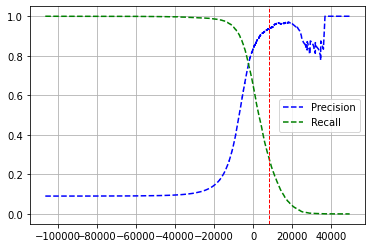

In [24]:
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)

In [25]:
def plot_precision_vs_recall(precisions, recalls):
    i = np.argmax(precisions >= 0.90)
    max_precision = precisions[i]
    max_recall = recalls[i]
    plt.plot(
        recalls,
        precisions,
    )
    plt.axvline(max_recall, 0, max_precision, color="r", linewidth=1, linestyle="--")
    plt.axhline(max_precision, 0, max_recall, color="r", linewidth=1, linestyle="--")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()

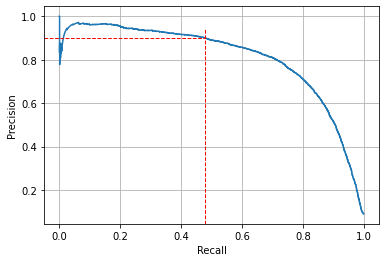

In [26]:
plot_precision_vs_recall(precisions, recalls)

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499143958

In [28]:
y_train_pred_90 = y_scores >= threshold_90_precision

print(classification_report(y_train_5, y_train_pred_90))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97     54579
        True       0.90      0.48      0.63      5421

    accuracy                           0.95     60000
   macro avg       0.93      0.74      0.80     60000
weighted avg       0.95      0.95      0.94     60000



## The ROC Curve

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")  # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()

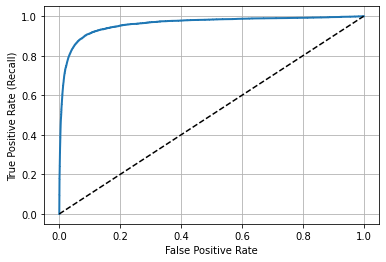

In [31]:
plot_roc_curve(fpr, tpr)

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba"
)

In [34]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

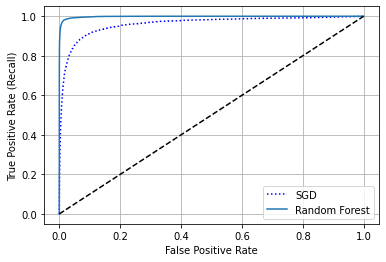

In [35]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0, 1], [0, 1], "k--")  # Dashed diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid()

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

- binary classifier - distinguish between two classes
- multiclass classifier - distinguish between more than two classes (e.g. random forest, naive bayes, sgd)

In [37]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train.values, y_train)

SVC()

In [38]:
some_digit = X_test.iloc[0]
svm_clf.predict([some_digit])

array([7], dtype=uint8)

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.80895496, -0.30212376,  6.19343167,  8.29375992,  1.71167996,
         4.76436748,  0.69153837,  9.31783975,  2.75699419,  7.28292338]])

In [40]:
np.argmax(some_digit_scores)

7

In [41]:
svm_clf.classes_[7]

7

In [42]:
%%time

# SVC uses OvO (One-versus-one) by default. To change it to OvR.
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train.values, y_train)

OneVsRestClassifier(estimator=SVC())

In [43]:
ovr_clf.predict([some_digit])

array([7], dtype=uint8)

In [44]:
ovr_clf.estimators_

[SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]

In [45]:
sgd_clf.decision_function([some_digit])

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([-8542.1753957])

In [46]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [53]:
%%time

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

CPU times: user 13min 53s, sys: 959 ms, total: 13min 54s
Wall time: 13min 54s


array([0.8983, 0.891 , 0.9018])

## Error analysis

In [54]:
%%time

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

CPU times: user 13min 49s, sys: 1 s, total: 13min 50s
Wall time: 13min 49s


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

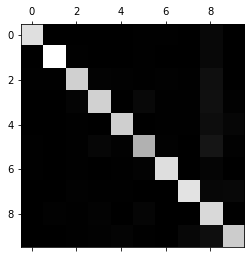

In [55]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

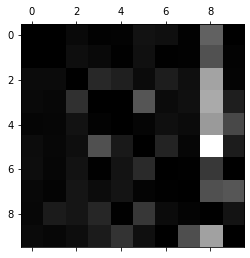

In [57]:
rows_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / rows_sum

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

## Multilabel Classification

In [64]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train.values, y_multilabel)

KNeighborsClassifier()

In [66]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [67]:
%%time

from sklearn.metrics import f1_score

# Example of evaluating a multilabel classifier, using F1 score.
# The score is the average f1 score across all labels.
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

## Multioutput Classification

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train.values + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test.values + noise

y_train_mod = X_train.values
y_test_mod = X_test.values

CPU times: user 7.81 s, sys: 534 ms, total: 8.34 s
Wall time: 7.96 s


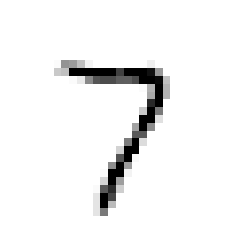

In [76]:
%%time

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])

def plot_digit(digit):
    digit_image = digit.reshape(28, 28)
    plt.imshow(digit_image, cmap="binary")
    plt.axis("off")
    
plot_digit(clean_digit)

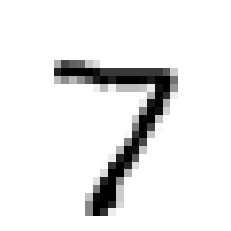

In [79]:
plot_digit(np.array(some_digit))